In [1]:
import fenics as fn
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import mu_0, epsilon_0

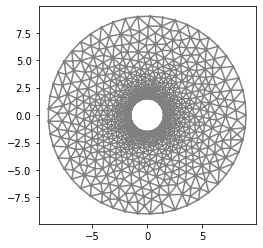

In [2]:
# Import mesh, subdomain and boundary information
mesh = fn.Mesh('geo.xml')
subdomains = fn.MeshFunction("size_t", mesh, 'geo_physical_region.xml')
boundaries = fn.MeshFunction('size_t', mesh, 'geo_facet_region.xml')
fn.plot(mesh)
plt.show()

In [3]:
# Define the function space
P1 = fn.FiniteElement("Lagrange", mesh.ufl_cell(), 1)
V = fn.FunctionSpace(mesh, 'CG', 2)

In [4]:
# Define measures for performing integrals
dx = fn.Measure('dx', domain=mesh, subdomain_data=subdomains)
ds = fn.Measure('ds', domain=mesh, subdomain_data=boundaries)

In [5]:
# Define the boundary conditions
voltage = 25
inner_boundary = fn.DirichletBC(V, fn.Constant(voltage), boundaries, 2)
outer_boundary = fn.DirichletBC(V, fn.Constant(0), boundaries, 3)
bcs =[inner_boundary, outer_boundary]

In [6]:
# Solve the Poisson Equation
u = fn.TrialFunction(V)
v = fn.TestFunction(V)
a = fn.dot(fn.grad(u), fn.grad(v)) * dx
L = fn.Constant('0') * v * dx
u = fn.Function(V)
fn.solve(a == L, u, bcs)

# Electric Potential

In [7]:
# Define some constants
epsilon_r = 3
inner_radius = 1.5
outer_radius = 9

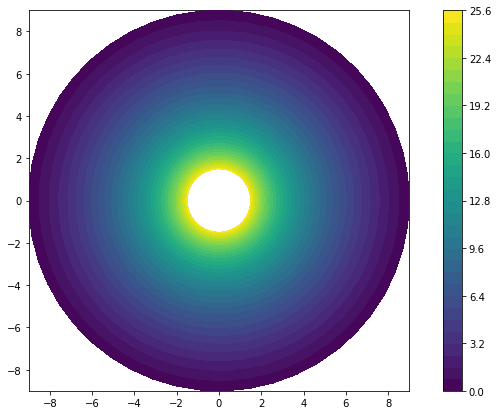

In [8]:
# Plot the electric potential
%matplotlib inline
plt.figure(figsize=(12,7))
fn.plot(mesh, linewidth=0.5)
p = fn.plot(u, zorder=3)
plt.colorbar(p)
plt.savefig('pictures/electric_potential.png', bbox_inches='tight')
plt.show()

# Electric Field

In [9]:
E = -fn.grad(u)

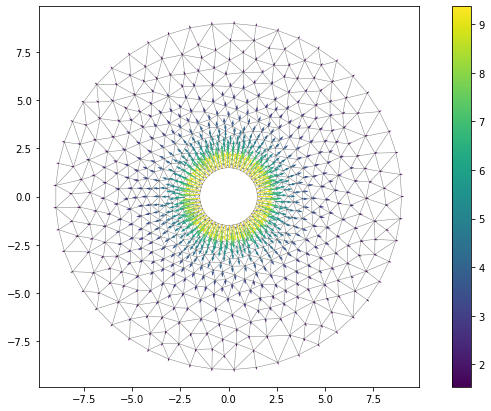

In [10]:
# Plot the electric field
%matplotlib inline
plt.figure(figsize=(12,7))
fn.plot(mesh, linewidth=0.5)
p = fn.plot(E, zorder=3)
plt.colorbar(p)
plt.savefig('pictures/electric_field.png', bbox_inches='tight')
plt.show()

In [11]:
def analytical_e(a, b, va, vb, x, y):
    return (va - vb)/np.log(b/a) * 1/np.sqrt(x**2 + y**2)

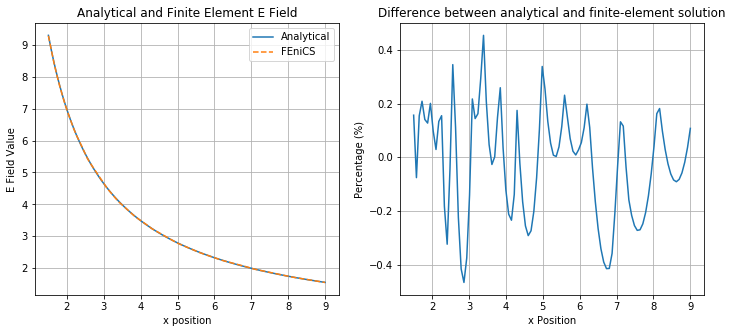

In [12]:
x = np.linspace(1.5, 9, 100)
y = np.zeros(len(x))

comparison_ana_e = analytical_e(1.5, 9, voltage, 0, x, y)
comparison_fen_e = np.array(list(map(fn.project(E), zip(x, y))))[:, 0]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(x, comparison_ana_e, label="Analytical")
ax[0].plot(x, comparison_fen_e, '--', label="FEniCS")
ax[1].plot(x, (comparison_ana_e - comparison_fen_e)/comparison_ana_e * 100)
ax[0].set_xlabel("x position")
ax[0].set_ylabel("E Field Value")
ax[0].set_title("Analytical and Finite Element E Field")
ax[0].grid()
ax[0].legend(loc=0)
ax[1].set_xlabel("x Position")
ax[1].set_ylabel("Percentage (%)")
ax[1].set_title("Difference between analytical and finite-element solution")
ax[1].grid()
plt.savefig('pictures/e_field_comparison.png', bbox_inches='tight')
plt.show()

# H Field

In [13]:
# Define some unit vectors which will be used later
xhat = fn.Expression(('1.0', '0.0'), V, degree=1)
yhat = fn.Expression(('0.0', '1.0'), V, degree=1)

In [14]:
# calculate the H field
z_tem = fn.Constant(np.sqrt(mu_0/epsilon_0/epsilon_r))
e_x = fn.dot(E, xhat)
e_y = fn.dot(E, yhat)
h = 1/z_tem * fn.as_vector([-e_y, +e_x])

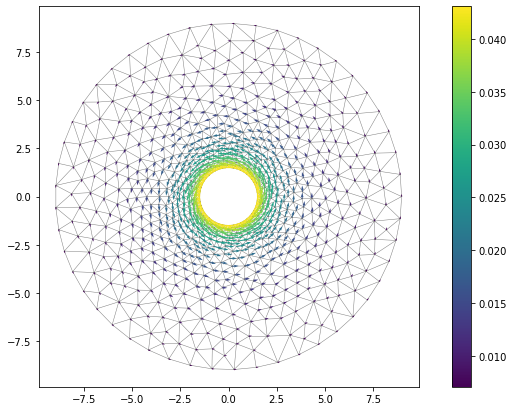

In [15]:
# Plot the H field
%matplotlib inline
plt.figure(figsize=(12,7))
fn.plot(mesh, linewidth=0.5)
p = fn.plot(h, zorder=2)
plt.colorbar(p)
plt.savefig('pictures/h_field.png', bbox_inches='tight')
plt.show()

In [16]:
def analytical_h(a, b, va, vb, epsilon_r, x, y):
    wave_impedance = np.sqrt(mu_0 / epsilon_0 / epsilon_r)
    return 1/wave_impedance * (va - vb)/np.log(b/a) * 1/np.sqrt(x**2 + y**2)

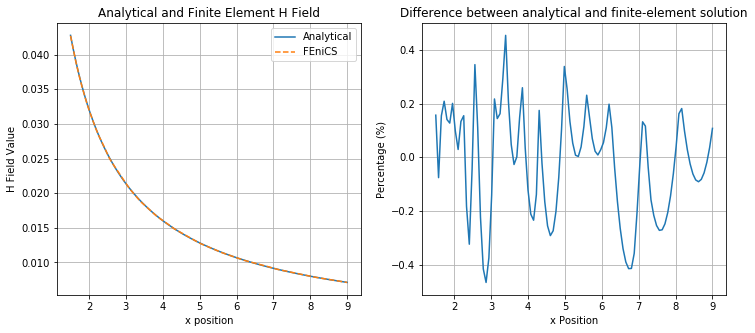

In [17]:
x = np.linspace(1.5, 9, 100)
y = np.zeros(len(x))

comparison_ana_h = analytical_h(1.5, 9, voltage, 0, epsilon_r, x, y)
comparison_fen_h = np.array(list(map(fn.project(h), zip(x, y))))[:, 1]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(x, comparison_ana_h, label="Analytical")
ax[0].plot(x, comparison_fen_h, '--', label="FEniCS")
ax[1].plot(x, (comparison_ana_h - comparison_fen_h)/comparison_ana_h * 100)
ax[0].set_xlabel("x position")
ax[0].set_ylabel("H Field Value")
ax[0].set_title("Analytical and Finite Element H Field")
ax[0].grid()
ax[0].legend(loc=0)
ax[1].set_xlabel("x Position")
ax[1].set_ylabel("Percentage (%)")
ax[1].set_title("Difference between analytical and finite-element solution")
ax[1].grid()
plt.savefig('pictures/h_field_comparison.png', bbox_inhes='tight')
plt.show()

## 3.3 - Current and Characteristic Impedance

In [18]:
# Calculate the expected current
def analytical_current(a, b, va, vb, epsilon_r):
    return 2*np.pi*np.sqrt(epsilon_0*epsilon_r/mu_0) * (va - vb)/np.log(b/ a)

analytical_current(1.5, 9, voltage, 0, epsilon_r)

0.4030604905306106

### Line Integral Method

0.4030324186090801


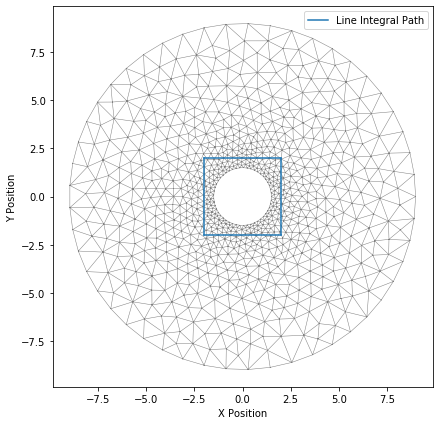

In [19]:
var = np.linspace(-2, 2, 100)
con = np.ones(len(var)) * 2

projected_h = fn.project(h)
h_right = np.array(list(map(projected_h, zip(con, var))))
h_top = np.array(list(map(projected_h, zip(var, con))))
h_left = np.array(list(map(projected_h, zip(-con, var))))
h_bottom = np.array(list(map(projected_h, zip(var, -con))))

dl = var[1] - var[0]
current_1 = np.trapz(h_right[:, 1], dx=dl)
current_2 = np.trapz(h_top[:, 0], dx=-dl)
current_3 = np.trapz(h_left[:, 1], dx=-dl)
current_4 = np.trapz(h_bottom[:, 0], dx=dl)

current = current_1 + current_2 + current_3 + current_4
print(current)

plt.figure(figsize=(12, 7))
fn.plot(mesh, linewidth=0.5)
plt.plot(con, var, 'C0', label='Line Integral Path')
plt.plot(-con, var, 'C0')
plt.plot(var, con, 'C0')
plt.plot(var, -con, 'C0')
plt.legend(loc=0)
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.show()

### Surface Current Method

In [20]:
# calculate current from surface current
nhat = fn.FacetNormal(mesh)
k = (fn.dot(h, yhat) * fn.dot(nhat, xhat) - fn.dot(nhat, yhat) * fn.dot(h, xhat))
current_2 = fn.assemble(-k * ds(2))
print(current_2)

0.3989443800251476


In [21]:
# integration over area and line to check surfaces are as-expected

# print(fn.assemble(1 * dx(1))) ## pi*9**2 - 2*(pi*0.5**2) = 252.9
# print(fn.assemble(1 * ds(2)))  # 2*pi*1.5 = 9.42

### Characteristic Impedance

In [22]:
# Calculate analytical characteristic impedance
def analytical_characteristic_impedance(a, b, epsilon_r):
    return 1/2/np.pi * np.sqrt(mu_0/epsilon_0/epsilon_r) * np.log(b/a)

analytical_characteristic_impedance(inner_radius, outer_radius, epsilon_r)

62.025429401648005

In [23]:
# Calculate z0 and print the result from both of the calculated currents
z_0 = np.abs(voltage/current)
print(z_0)
print(z_0 * current / current_2)

62.029749582622685
62.665377059388874


### Capacitance and Self-Inductance

In [24]:
def analytical_capacitance(eps_r, outer_radius, inner_radius):
    return 2*np.pi*epsilon_0*eps_r/np.log(outer_radius/inner_radius)

C = epsilon_0 * epsilon_r / (voltage)**2 * fn.assemble(E**2 * dx(1))
analytical_C = analytical_capacitance(epsilon_r, outer_radius, inner_radius)

print('C = {:.4e}'.format(C))
print('Analytical C = {:.4e}'.format(analytical_C))
print("Percentage Difference = {:.3f} %".format((C-analytical_C)/analytical_C * 100))

C = 9.3153e-11
Analytical C = 9.3147e-11
Percentage Difference = 0.006 %


In [25]:
def analytical_inductance(outer_radius, inner_radius):
    return mu_0/(2*np.pi) * np.log(outer_radius/inner_radius)

L = mu_0 / current**2 * fn.assemble(h**2 * dx(1))
analytical_L = analytical_inductance(outer_radius, inner_radius)

print('L = {:.4e}'.format(L))
print('Analytical L = {:.4e}'.format(analytical_L))
print("Percentage Difference = {:.3f} %".format((L-analytical_L)/analytical_L * 100))

L = 3.5842e-07
Analytical L = 3.5835e-07
Percentage Difference = 0.020 %


## 3.4 - Poynting Vector

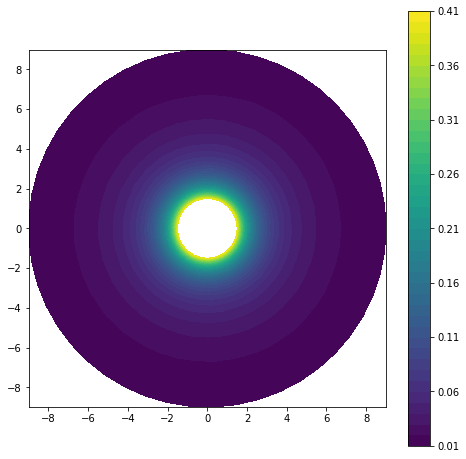

In [26]:
# Calculate the peak Poynting vector
S = (fn.dot(E, xhat)*fn.dot(h, yhat) -
           fn.dot(E,yhat)*fn.dot(h, xhat))

plt.figure(figsize=(8,8))
p = fn.plot(S, zorder=2)
plt.colorbar(p)
plt.savefig('pictures/poynting_vector.png', bbox_inhes='tight')
plt.show()

In [27]:
# Calculate analytical time-averaged Poynting vector
def analytical_poynting(a, b, va, vb, epsilon_r, x, y):
    s = np.sqrt(x**2 + y**2)
    return np.sqrt(epsilon_0 * epsilon_r / mu_0) * ((vb-va)/np.log(b/a)/s)**2

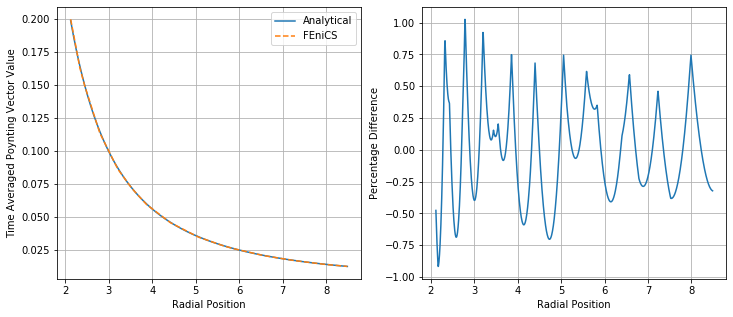

In [28]:
# Compare time-averaged Poynting vector results
projected_s = fn.project(S)
x = np.linspace(1.5, 6, 1000)
y = np.linspace(1.5, 6, 1000)

analytical_SS = analytical_poynting(1.5, 9, voltage, 0, epsilon_r, x, y)

SS = np.array(list(map(projected_s, zip(x, y))))

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(np.sqrt(x**2 + y**2), analytical_SS, label='Analytical')
ax[0].plot(np.sqrt(x**2 + y**2), SS, '--', label='FEniCS')
ax[0].set_xlabel("Radial Position")
ax[0].set_ylabel("Time Averaged Poynting Vector Value")
ax[0].legend(loc=0)
ax[0].grid()

ax[1].plot(np.sqrt(x**2 + y**2), (analytical_SS - SS)/analytical_SS * 100)
ax[1].set_xlabel("Radial Position")
ax[1].set_ylabel("Percentage Difference")
ax[1].grid()
plt.savefig('pictures/poynting_comparison.png', bbox_inhes='tight')
plt.show()

In [29]:
power = fn.assemble(S * dx(1))
print("Z_0 = {:.2f}".format(voltage**2 / power))
print("Current = {:.2f}".format(power/voltage))

Z_0 = 62.02
Current = 0.40


## 3.5 - Conductor and Dielectric Loss

In [30]:
# Define signal and material constants
frequency = 1e9
omega = 2*np.pi*frequency
conductivity = 5.8e7
skin_depth = np.sqrt(2/omega/mu_0/conductivity)  # m
epsilon_loss = 0.0002 * 8.85e-12

### Conductor Loss

In [31]:
# Calculate conductor loss
c_loss_inner = fn.assemble(k**2 * ds(2))
c_loss_outer = fn.assemble(k**2 * ds(3))
c_loss = 1/2/conductivity/skin_depth*(c_loss_inner + c_loss_outer)
print(c_loss)  # W/mm

8.168985599627055e-05


In [32]:
# Calculate the expected conductor loss
hand_c_loss = np.pi * epsilon_r * epsilon_0 * np.sqrt(omega/2/conductivity/mu_0) *  ((voltage-0)/np.log(outer_radius/inner_radius))**2 * (1/inner_radius + 1/outer_radius)
print(hand_c_loss)

8.295680099851824e-05


### Dielectric Loss 

In [33]:
# Calculate the dielectric loss
d_loss = omega * epsilon_loss / 2 * fn.assemble(E**2 * dx(1)) /1e3  # constant is to convert W/m -> W/mm
print(d_loss)

1.2187874819395503e-05


In [34]:
# Calculate the expected dielectric loss
analytical_d_loss = np.pi * omega * epsilon_loss * (voltage-0)**2/np.log(outer_radius/inner_radius) / 1e3
print(analytical_d_loss)

1.2187182550132156e-05


### Loss Parameter

In [35]:
# Calculate the attenuation constant - various ways of getting P0
P0 = 0.5 * voltage**2/z_0
# P0 = fn.assemble(S * dx(1))
# P0 = 0.5 * current**2 * z_0
# P0 = 0.5 * voltage * current

alpha = (c_loss + d_loss)/(2*P0)
print(alpha)

9.317139414209002e-06


In [36]:
# Calculate expected attenuation constant
analytical_p0 = analytical_current(inner_radius, outer_radius, voltage, 0, epsilon_r) * voltage /2 
paper_alpha = (hand_c_loss + analytical_d_loss)/2/analytical_p0
print(paper_alpha)

9.442154295341398e-06


### Q-Factor

In [37]:
# Calculate quality factor
c = 1/np.sqrt(epsilon_0 * mu_0 * epsilon_r)
wavelength = c/frequency  * 1e3  # m -> mm
beta = 2*np.pi/wavelength
Q = beta/(2*alpha)
print('{:.2e}'.format(Q))

1.95e+03


### s-parameter

In [38]:
# Calculate s-parameter for a given length
l = 10 * 1e3
s21 = np.exp(-alpha * l)
print('{:.4f}'.format(s21))
print('{:.2f} dB'.format(20*np.log10(s21)))

0.9110
-0.81 dB


output some files

In [39]:
electric_potential_file = fn.File('output/electric_potential.pvd')
electric_potential_file << fn.project(u)

electric_field_file = fn.File('output/electric_field.pvd')
electric_field_file << fn.project(E)

h_field_file = fn.File('output/h_field.pvd')
h_field_file << fn.project(h)